# Imports and Settings

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity, BallTree
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from matplotlib.ticker import ScalarFormatter
import os
from colorama import Fore, Style
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import json
import plotly.express as px
from haversine import haversine, Unit
import math

# File loading


In [44]:
columns = [
    "vehicleId", 
    "lat", 
    "lng", 
    # "dateStored", 
    "velocity",
    # "odometer", 
    # "engineVoltage", 
    "dateStoredHuman", 
    # "dateOnlyStoredHuman",    
    # "timeOnly",
    "bearing",
    "orientation", 
    "bearing_diff",
    "seconds_diff", 
    "acceleration",
    "isProblem",
    "trip_id",
    "velocity_diff"
]


input_dir   = "../../DataSets/API_Responses/Vehicle_Data/"
filename    = "all_vehicle_responses.csv"

## Enable matloblib UI backend

In [45]:
# %matplotlib tk

## Save plots file

In [46]:
PLOT_FOLDER_PATH = "./Plots/"


In [47]:
def merge_csv_file(input_dir, filename, columns):
    input_file = os.path.join(input_dir, filename)

    if not os.path.exists(input_file):
        raise FileNotFoundError(f"File '{filename}' not found in directory '{input_dir}'")

    try:
        # Read the CSV while allowing missing columns
        df = pd.read_csv(input_file, usecols=lambda x: x.strip() in columns, encoding='utf-8')
    except Exception as e:
        raise ValueError(f"Error reading '{input_file}': {e}")

    return df



merged_dfs = merge_csv_file(input_dir, filename, columns)
print(merged_dfs.head())


   vehicleId        lat        lng  velocity      dateStoredHuman  \
0          1  37.510833  22.385710       0.0  2024-06-06 17:02:17   
1          1  37.510603  22.385977       0.0  2024-06-06 17:02:20   
2          1  37.510640  22.385927       6.0  2024-06-06 17:02:25   
3          1  37.510750  22.385907       7.0  2024-06-06 17:02:31   
4          1  37.510877  22.385698      26.0  2024-06-06 17:02:37   

   seconds_diff  trip_id     bearing orientation  bearing_diff  velocity_diff  \
0           NaN        0  137.402376   Southeast          0.00            0.0   
1           3.0        0  312.778670   Northwest        175.38            0.0   
2           5.0        0  351.785725       North         39.01            6.0   
3           6.0        0  307.481149   Northwest         44.30            1.0   
4           6.0        0  318.388767   Northwest         10.91           19.0   

   acceleration  isProblem  
0      0.000000          0  
1      0.000000          0  
2      0.33

Set **Bounding Box** only for **Τρίπολη**

# Data Overview

Text(0.5, 1.0, 'Density of problem points on spatial coordinates')

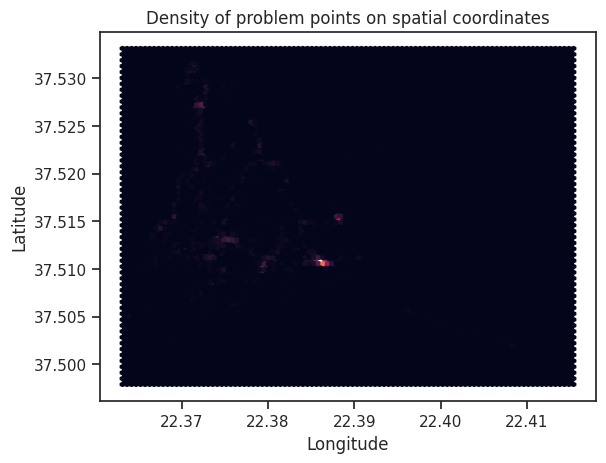

In [48]:
df = merged_dfs
df_danger = df[df['isProblem'] == 1]
# df_danger = df[df['vehicleId'] == 15]


sns.set_theme(style="ticks")
fig, ax = plt.subplots()
#sns.jointplot(x=df_danger['lng'], y=df_danger['lat'], kind="hex", color="#4CB391", ax=ax)
ax.hexbin(x=df_danger['lng'], y=df_danger['lat'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.ticklabel_format(style='plain', axis='both')  # Disable scientific notation


ax.set_title('Density of problem points on spatial coordinates')

### Init DF15 (VehicleId == 15)

In [49]:
# df15 = df[df["vehicleId"] == 15]
# df15 = df15.head(500)
# df15_problem = df15[df15['isProblem'] == 1]
# plt.plot(df15.index, df15['acceleration'])
# plt.title('Acceleration vs Index')
# plt.ylabel('Acceleration')
# plt.xlabel('Index')
# plt.scatter(df15_problem.index, df15_problem['acceleration'], color='red')

# len(df15)

In [50]:
df_danger[['lng', 'lat']].describe()

,lng,lat
count,2194.000000,2194.000000
mean,22.378132,37.515329
std,0.006988,0.006203
min,22.363152,37.497893
25%,22.372422,37.510810
50%,22.376219,37.513109
75%,22.385158,37.519328
max,22.415382,37.533140


# Clustering

In [51]:
# #### MOCK DATA #####
#
# data = {
#     'lng': np.random.uniform(-180, 180, 200),
#     'lat': np.random.uniform(-90, 90, 200)
# }
# df = pd.DataFrame(data)
# df_danger = df

/tmp/ipykernel_16252/1621334586.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


Plot saved to ./Plots/


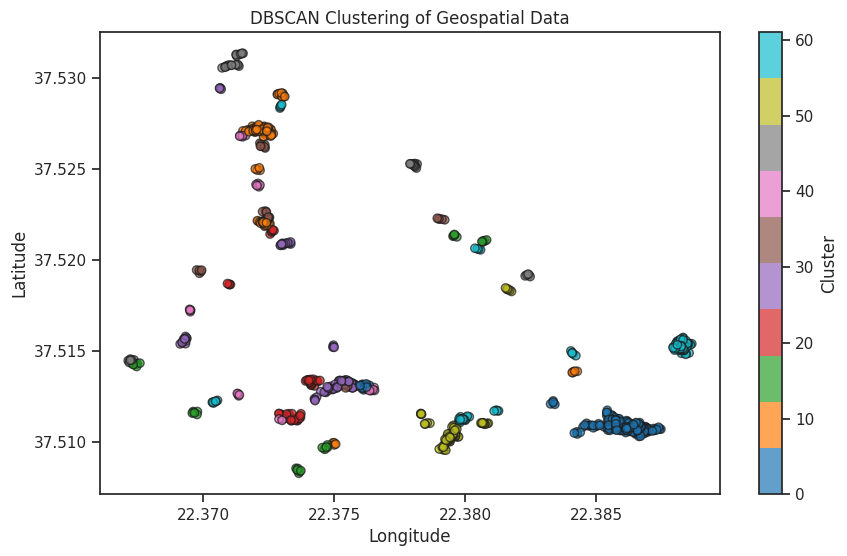

In [52]:
# Extracting the coordinates
coords = df_danger[['lng', 'lat']].values

# Standardizing the data for better clustering performance
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Applying DBSCAN
dbscan = DBSCAN(eps=0.02, min_samples=4)  # Adjust eps as needed
clusters = dbscan.fit_predict(coords_scaled)

df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


df_danger_cluster = df_danger[df_danger['cluster'] > -1]


# %matplotlib inline
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(df_danger_cluster['lng'], df_danger_cluster['lat'], c=df_danger_cluster['cluster'], cmap='tab10', edgecolors='k', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Geospatial Data')
plt.colorbar(label='Cluster')

# Save the plot
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


In [53]:
df_danger.columns

Index(['vehicleId', 'lat', 'lng', 'velocity', 'dateStoredHuman',
       'seconds_diff', 'trip_id', 'bearing', 'orientation', 'bearing_diff',
       'velocity_diff', 'acceleration', 'isProblem', 'cluster'],
      dtype='object')

In [54]:
df_danger.describe()

,vehicleId,lat,lng,velocity,seconds_diff,trip_id,bearing,bearing_diff,velocity_diff,acceleration,isProblem,cluster
count,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000,2194.0,2194.000000
mean,7.559708,37.515329,22.378132,14.578851,3.530994,143.736554,181.834256,73.738127,-11.404284,-1.070413,1.0,9.009116
std,4.078162,0.006203,0.006988,14.990388,3.172815,144.158906,107.172766,91.240364,9.917360,1.123217,0.0,18.368397
min,1.000000,37.497893,22.363152,0.000000,1.000000,0.000000,0.000000,0.000000,-141.000000,-14.722222,1.0,-1.000000
25%,7.000000,37.510810,22.372422,6.000000,2.000000,23.000000,93.838222,10.262500,-14.000000,-1.111111,1.0,-1.000000
50%,7.000000,37.513109,22.376219,10.000000,3.000000,90.000000,186.731220,33.035000,-9.000000,-0.763889,1.0,-1.000000
75%,9.000000,37.519328,22.385158,18.000000,5.000000,207.000000,276.508284,102.567500,-5.000000,-0.555556,1.0,9.000000
max,20.000000,37.533140,22.415382,123.000000,50.000000,505.000000,359.405846,358.230000,-2.000000,-0.505051,1.0,61.000000


## Showing convex hulls

/tmp/ipykernel_16252/113842607.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters


Plot saved to ./Plots/


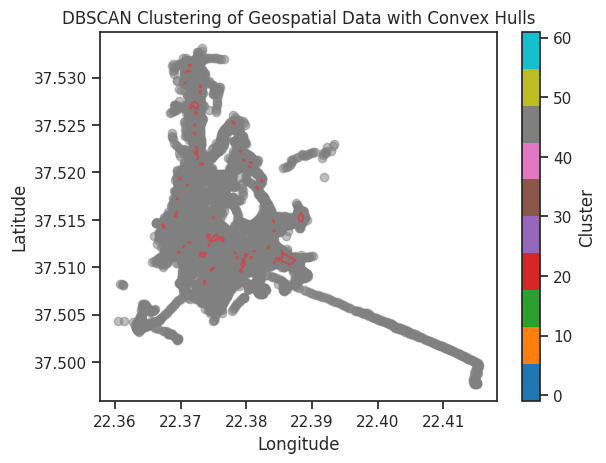

In [55]:
def plot_convex_hulls(df, clusters, normal_df_points):
    unique_clusters = set(clusters)
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters

    fig, ax = plt.subplots()  # Create figure and axis objects

    # Plot points first for colorbar
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', c=[colors(cluster)], s=10)

    ax.scatter(normal_df_points['lng'], normal_df_points['lat'], c='gray', alpha=0.5)

    # Plot Convex Hulls
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the loop
            ax.plot(cluster_points[hull_points, 0], cluster_points[hull_points, 1], 'r-')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('DBSCAN Clustering of Geospatial Data with Convex Hulls')

    # Create colorbar using scatter points
    cb = fig.colorbar(plt.cm.ScalarMappable(cmap="tab10", norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))),
                      ax=ax, label='Cluster')

    # Save the plot
    plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
    print(f"Plot saved to {PLOT_FOLDER_PATH}")

    plt.show()

plot_convex_hulls(df_danger_cluster, clusters, df[df['isProblem'] == 0])


## Get specific **Cluster's BBOX**

In [56]:
def get_bbox_of_clusters(df, clusters):
    cluster_bboxes = {}

    # Iterate over unique clusters (excluding -1 for noise)
    unique_clusters = sorted(set(clusters) - {-1})  # Exclude noise points (-1)

    for cluster in unique_clusters:
        # Filter the points of the current cluster
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']]
        
        # Get the minimum and maximum lng and lat for the bounding box
        min_lng = cluster_points['lng'].min()
        max_lng = cluster_points['lng'].max()
        min_lat = cluster_points['lat'].min()
        max_lat = cluster_points['lat'].max()

        # Store the bounding box for the current cluster
        cluster_bboxes[cluster] = {
            'min_lng': min_lng,
            'max_lng': max_lng,
            'min_lat': min_lat,
            'max_lat': max_lat
        }

    return cluster_bboxes

cluster_bboxes = get_bbox_of_clusters(df_danger_cluster, clusters)

# Display the bounding boxes for each cluster
for cluster, bbox in cluster_bboxes.items():
    print(f"Cluster {cluster}: {bbox}")


Cluster 0: {'min_lng': 22.3853133, 'max_lng': 22.3874666, 'min_lat': 37.5102916, 'max_lat': 37.5114683}
Cluster 1: {'min_lng': 22.3841633, 'max_lng': 22.3843916, 'min_lat': 37.510425, 'max_lat': 37.5105433}
Cluster 2: {'min_lng': 22.3848866, 'max_lng': 22.3851333, 'min_lat': 37.5107683, 'max_lat': 37.5109899}
Cluster 3: {'min_lng': 22.3844933, 'max_lng': 22.3848033, 'min_lat': 37.510815, 'max_lat': 37.5110133}
Cluster 4: {'min_lng': 22.3854, 'max_lng': 22.3854449, 'min_lat': 37.5114433, 'max_lat': 37.5117283}
Cluster 5: {'min_lng': 22.3832566, 'max_lng': 22.3834216, 'min_lat': 37.5120583, 'max_lat': 37.512245}
Cluster 6: {'min_lng': 22.3759916, 'max_lng': 22.3763466, 'min_lat': 37.512855, 'max_lat': 37.5131816}
Cluster 7: {'min_lng': 22.3749533, 'max_lng': 22.3750599, 'min_lat': 37.509825, 'max_lat': 37.509945}
Cluster 8: {'min_lng': 22.3840833, 'max_lng': 22.3842783, 'min_lat': 37.5138016, 'max_lat': 37.5138783}
Cluster 9: {'min_lng': 22.3715183, 'max_lng': 22.3726783, 'min_lat': 37.5

## Plot Orientations with Convex Hulls

### Prepare the DF

In [57]:
# *Get specific columns 
_ = merged_dfs.copy()
bearings_df = _[['vehicleId', 'lat', 'lng', 'dateStoredHuman' ,'bearing', 'orientation', 'seconds_diff', 'trip_id']]
print(bearings_df)

# Filter for vehicleId == 1
df_vehicle1 = df[df['vehicleId'] == 1]

# Count occurrences of each trip_id
trip_counts = df_vehicle1['trip_id'].value_counts()

# Get the trip_id with the highest count
most_frequent_trip_id = trip_counts.idxmax()

# Display the result
print(f"The trip_id with the most rows for vehicleId 1 is: {most_frequent_trip_id}")


       vehicleId        lat        lng      dateStoredHuman     bearing  \
0              1  37.510833  22.385710  2024-06-06 17:02:17  137.402376   
1              1  37.510603  22.385977  2024-06-06 17:02:20  312.778670   
2              1  37.510640  22.385927  2024-06-06 17:02:25  351.785725   
3              1  37.510750  22.385907  2024-06-06 17:02:31  307.481149   
4              1  37.510877  22.385698  2024-06-06 17:02:37  318.388767   
...          ...        ...        ...                  ...         ...   
28443         20  37.531460  22.369768  2025-03-06 13:09:13  231.663210   
28444         20  37.531275  22.369473  2025-03-06 13:09:15  235.207818   
28445         20  37.531122  22.369195  2025-03-06 13:09:19  278.389323   
28446         20  37.531148  22.368967  2025-03-06 13:09:21  294.596339   
28447         20  37.531243  22.368705  2025-03-06 13:09:24         NaN   

      orientation  seconds_diff  trip_id  
0       Southeast           NaN        0  
1       North

### Get trip_id's rows

In [58]:
print(df[(df['vehicleId'] == 1) & (df['trip_id'] == most_frequent_trip_id)].head(5))

     vehicleId        lat        lng  velocity      dateStoredHuman  \
946          1  37.510722  22.387033      16.0  2024-06-08 17:32:23   
947          1  37.510692  22.387185       8.0  2024-06-08 17:32:30   
948          1  37.510670  22.387042       9.0  2024-06-08 17:32:38   
949          1  37.510645  22.386773      22.0  2024-06-08 17:32:41   
950          1  37.510685  22.386552      34.0  2024-06-08 17:32:43   

     seconds_diff  trip_id     bearing orientation  bearing_diff  \
946         240.0       64  103.998723        East          0.00   
947           7.0       64  259.248208        West        155.25   
948           8.0       64  263.300439        West          4.05   
949           3.0       64  282.783117        West         19.48   
950           2.0       64  277.535628        West          5.25   

     velocity_diff  acceleration  isProblem  
946          -40.0      0.000000          0  
947           -8.0     -0.317460          0  
948            1.0      0.

## Plot std deviation

### 2️⃣ Violin Plot (Distribution)

Plot saved to ./Plots/


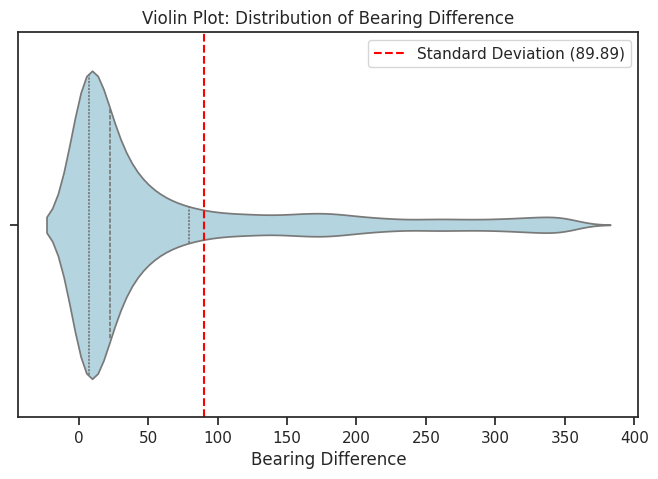

In [59]:
# Ensure std_dev is calculated
std_dev = merged_dfs['bearing_diff'].std()

plt.figure(figsize=(8, 5))

# Create the violin plot
sns.violinplot(x=merged_dfs['bearing_diff'], inner="quartile", color="lightblue")

# Mark the standard deviation with a vertical line
plt.axvline(x=std_dev, color='red', linestyle='--', label=f'Standard Deviation ({std_dev:.2f})')

# Labels and title
plt.xlabel('Bearing Difference')
plt.title('Violin Plot: Distribution of Bearing Difference')

# Show legend
plt.legend()

# Save the plot
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

# Display the plot
plt.show()


In [60]:
print((merged_dfs['bearing_diff'] < 0).sum())


0


### 3️⃣ Boxplot (Detect Outliers)

Plot saved to ./Plots/


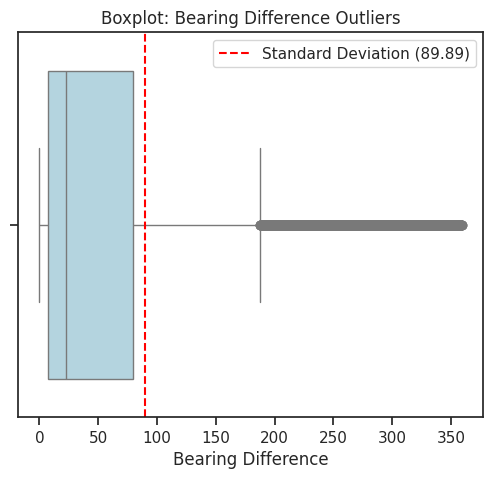

In [61]:
plt.figure(figsize=(6, 5))
sns.boxplot(x=merged_dfs['bearing_diff'], color='lightblue')

# Mark the standard deviation
plt.axvline(x=std_dev, color='red', linestyle='--', label=f'Standard Deviation ({std_dev:.2f})')

plt.xlabel('Bearing Difference')
plt.title('Boxplot: Bearing Difference Outliers')
plt.legend()

# Save the plot
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


## Plot bearings vs seconds diff 

### ✅ Option 1: Matplotlib (simple, static plot)

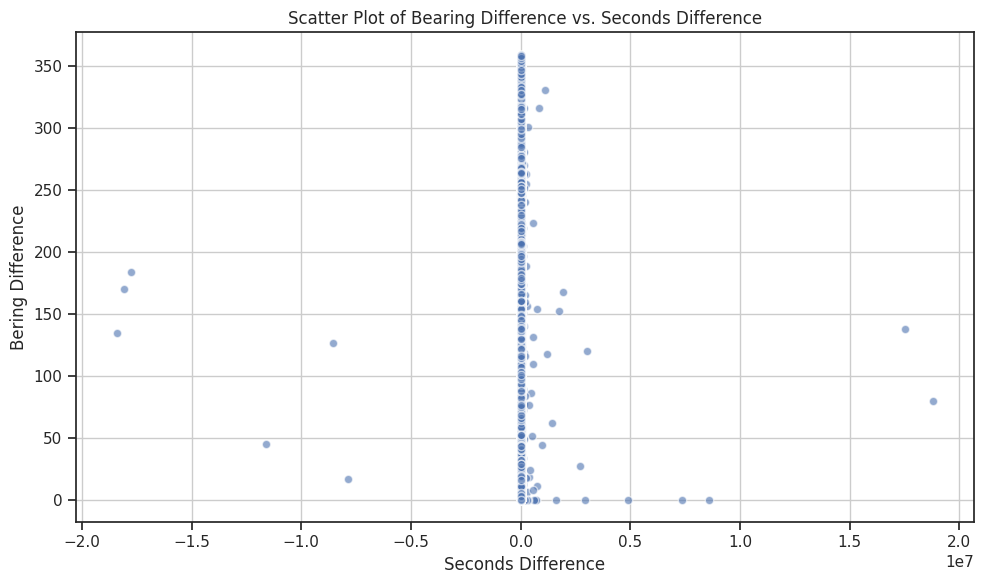

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(merged_dfs['seconds_diff'], merged_dfs['bearing_diff'], alpha=0.6, edgecolors='w')
plt.title('Scatter Plot of Bearing Difference vs. Seconds Difference')
plt.xlabel('Seconds Difference')
plt.ylabel('Bering Difference')
plt.grid(True)
plt.tight_layout()
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Scatter_bearings_vs_seconds_diff.png")
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()


## Plot bearings vs 10 seconds_diff

/tmp/ipykernel_16252/3031239980.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 20)  # Using the 'tab20' colormap


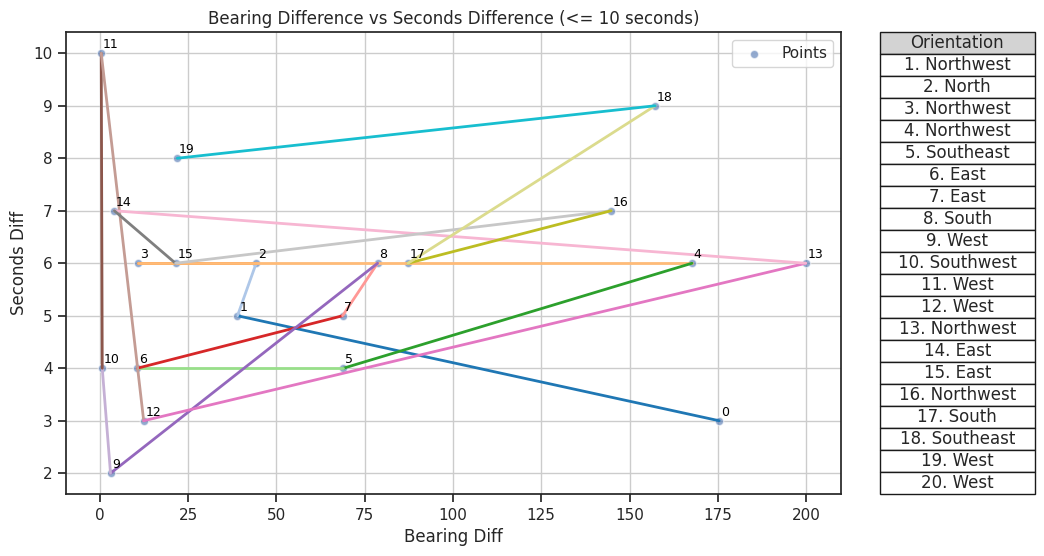

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame and take only the first 20 rows
filtered_df = merged_dfs[merged_dfs['seconds_diff'] <= 10].head(20)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot (swapped axes)
ax.scatter(
    filtered_df['bearing_diff'],
    filtered_df['seconds_diff'],
    alpha=0.6,
    edgecolors='w',
    label='Points'
)

# Generate a list of 20 distinct colors using a colormap
colors = plt.cm.get_cmap('tab20', 20)  # Using the 'tab20' colormap

# Plot segments with changing color for each segment
for i in range(len(filtered_df) - 1):
    # Get the x and y values for the two points
    x_start = filtered_df['bearing_diff'].iloc[i]
    y_start = filtered_df['seconds_diff'].iloc[i]
    x_end = filtered_df['bearing_diff'].iloc[i + 1]
    y_end = filtered_df['seconds_diff'].iloc[i + 1]

    # Assign a unique color for each segment from the 'tab20' colormap
    color = colors(i)  # Get a different color for each segment

    # Plot each segment with its own color
    ax.plot([x_start, x_end], [y_start, y_end], color=color, lw=2)

# Add incremental labels
for i, (x, y) in enumerate(zip(filtered_df['bearing_diff'], filtered_df['seconds_diff'])):
    ax.text(x + 0.5, y + 0.1, str(i), fontsize=9, color='black')

# Prepare the orientation labels
orientation_list = [f"{i+1}. {orientation}" for i, orientation in enumerate(filtered_df['orientation'])]

# Prepare cell text for the table
cell_text = [[orientation] for orientation in orientation_list]

# Add the table on the right side of the plot (without color)
table = ax.table(cellText=cell_text,
                 colLabels=['Orientation'],
                 loc='right',
                 cellLoc='center',
                 colColours=['lightgray'],  # Keep the header background color if desired
                 bbox=[1.05, 0, 0.2, 1])  # Adjust bbox for position and size

# Labels and title
ax.set_title('Bearing Difference vs Seconds Difference (<= 10 seconds)')
ax.set_xlabel('Bearing Diff')
ax.set_ylabel('Seconds Diff')
ax.grid(True)
ax.legend()





plot_save_path = os.path.join(PLOT_FOLDER_PATH, "bearings_vs_seconds_diff.png")
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()


# Trajectory Analysis

## Calculate distances in meters

In [64]:
def compute_distances(group):
    group = group.copy()
    group['current_coords'] = list(zip(group['lat'], group['lng']))
    group['prev_coords'] = group['current_coords'].shift()
    
    group['distance_meters'] = group.apply(
        lambda row: haversine(row['prev_coords'], row['current_coords'], unit=Unit.METERS)
        if pd.notnull(row['prev_coords']) else 0.0,
        axis=1
    )
    
    group['distance_meters'] = group['distance_meters'].round(2)
    return group

merged_dfs = merged_dfs.groupby('trip_id', group_keys=False).apply(compute_distances)


/tmp/ipykernel_16252/1627941565.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_dfs = merged_dfs.groupby('trip_id', group_keys=False).apply(compute_distances)


### Plot trajectory for 100 meters

Number of rows in filtered data: 5


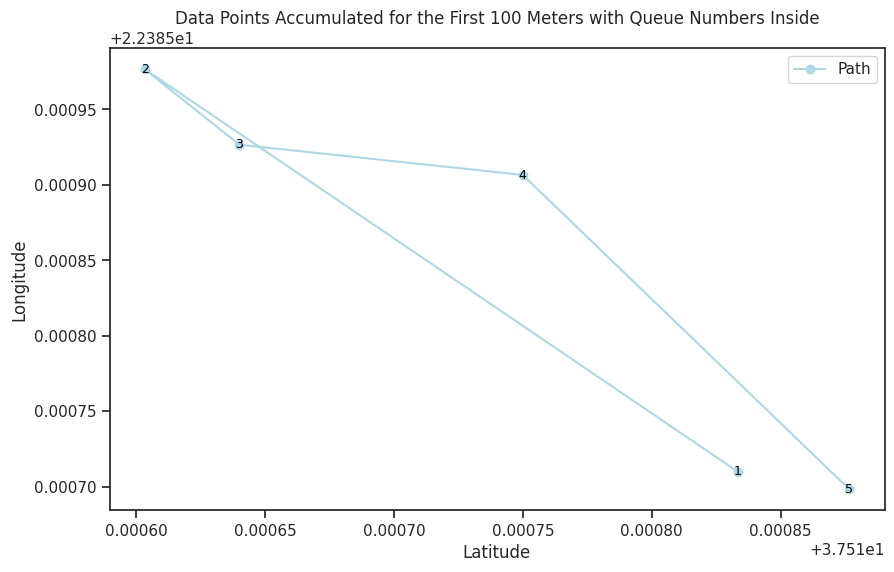

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the cumulative distance
cumulative_distance = 0
filtered_df = []

# Loop through the DataFrame and accumulate 'distance_meters' until it reaches 100 meters
for index, row in merged_dfs.iterrows():
    cumulative_distance += row['distance_meters']
    if cumulative_distance <= 100:
        filtered_df.append(row)
    else:
        break

# Convert the list of rows to a DataFrame
filtered_df = pd.DataFrame(filtered_df)

# Print how many rows are in the filtered data
print(f"Number of rows in filtered data: {len(filtered_df)}")

# Plot the path for the accumulated rows
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the path (for reference)
ax.plot(filtered_df['lat'], filtered_df['lng'], marker='o', color='lightblue', label='Path')

# Add queue number labels inside each data point
for i, (lat, lng) in enumerate(zip(filtered_df['lat'], filtered_df['lng'])):
    # Place the text directly at the point (lat, lng)
    ax.text(lat, lng, str(i+1), fontsize=9, color='black', ha='center', va='center')

# Add labels, title, and legend
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Data Points Accumulated for the First 100 Meters with Queue Numbers Inside')
ax.legend()

# Show the plot
plt.show()


### Locate danger **slaloms**

In [77]:
# Assuming these are the columns you want to select from the target DataFrame
_columns = [
    'lat',
    'lng',
    'seconds_diff',
    'bearing_diff',
    'velocity_diff'
]

# Step 1: Count rows per (vehicleId, trip_id)
grouped = df.groupby(['vehicleId', 'trip_id']).size().reset_index(name='row_count')

# Step 2: Find max row count per vehicle
max_per_vehicle = grouped.groupby('vehicleId')['row_count'].max().reset_index()

# Step 3: Merge to get trip_ids that match max row counts per vehicle
result = pd.merge(grouped, max_per_vehicle, on=['vehicleId', 'row_count'])

# Step 4: Find the single top (vehicleId, trip_id) with the absolute most rows
top_vehicle = result.loc[result['row_count'].idxmax()]

# Step 5: Store the results in variables
vehicle_id = top_vehicle['vehicleId']
trip_id = top_vehicle['trip_id']
row_count = top_vehicle['row_count']

# Print the results
print("Vehicle with most rows for a single trip_id:")
print(f"Vehicle ID: {vehicle_id}")
print(f"Trip ID: {trip_id}")
print(f"Row Count: {row_count}")

# Step 6: Filter the merged_dfs DataFrame using vehicle_id and trip_id
target_df = merged_dfs[(merged_dfs['vehicleId'] == vehicle_id) & (merged_dfs['trip_id'] == trip_id)]

# Step 7: Select only the specific columns from the target DataFrame
target_df_filtered = target_df[_columns]

# Print the filtered DataFrame (with the specified columns)
print("Filtered DataFrame with specified columns:")
print(target_df_filtered)


Vehicle with most rows for a single trip_id:
Vehicle ID: 15
Trip ID: 207
Row Count: 407
Filtered DataFrame with specified columns:
             lat        lng  seconds_diff  bearing_diff  velocity_diff
27443  37.512207  22.383467         758.0        310.94           -6.0
27444  37.512225  22.383440           1.0        112.95            6.0
27445  37.512143  22.383407           3.0        106.62            3.0
27446  37.512172  22.383355           4.0         54.57           -9.0
27447  37.512260  22.383353           2.0          2.56           13.0
...          ...        ...           ...           ...            ...
27845  37.531242  22.371522           1.0        184.03            1.0
27846  37.531267  22.371482           1.0         42.71            1.0
27847  37.531263  22.371428           2.0         72.81            0.0
27848  37.531217  22.371415           2.0          8.10           -2.0
27849  37.531183  22.371412          10.0        145.73           -9.0

[407 rows x 5 co

In [85]:
import pandas as pd
import math

# Global variable for the bearing threshold
BEARING_THRESHOLD = 30

# Your existing function to calculate bearing
def calculate_initial_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the initial compass bearing between two points.
    Returns the bearing in degrees (0° = North, clockwise to 360°).
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    delta_lon = lon2 - lon1

    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - \
        math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)

    initial_bearing = math.atan2(x, y)

    # Convert from radians to degrees and normalize to 0–360
    bearing_degrees = (math.degrees(initial_bearing) + 360) % 360
    return bearing_degrees

# Your existing function to convert bearing to orientation
def bearing_to_orientation(bearing):
    """
    Converts a numeric bearing into a compass direction.
    """
    directions = [
        "North", "North-East", "East", "South-East",
        "South", "South-West", "West", "North-West"
    ]
    idx = int(((bearing + 22.5) % 360) // 45)
    return directions[idx]

# Assuming target_df is already filtered
_columns = ['lat', 'lng', 'seconds_diff', 'bearing_diff', 'velocity_diff']

# Step 1: Filter the merged_dfs DataFrame using vehicle_id and trip_id
target_df = merged_dfs[(merged_dfs['vehicleId'] == vehicle_id) & (merged_dfs['trip_id'] == trip_id)]

# Step 2: Select only the specified columns and use the head(3) to get the first 3 rows
target_df_filtered = target_df[_columns].head(3)

# Debug: Check the filtered target_df
print("Filtered target_df (first 3 rows):")
print(target_df_filtered)

# Step 3: Calculate bearing and orientation between consecutive rows
bearings = []
orientations = []

# Calculate bearings and orientations for the first 2 points
for i in range(len(target_df_filtered) - 1):
    lat1, lon1 = target_df_filtered.iloc[i][['lat', 'lng']]
    lat2, lon2 = target_df_filtered.iloc[i + 1][['lat', 'lng']]
    
    bearing = calculate_initial_bearing(lat1, lon1, lat2, lon2)
    orientation = bearing_to_orientation(bearing)
    
    # Debug: Print the calculated bearing and orientation
    print(f"From Point {i + 1} to Point {i + 2}: Bearing = {bearing:.2f}°, Orientation = {orientation}")
    
    bearings.append(bearing)
    orientations.append(orientation)

# Step 4: Create bearing_diffs, ensure length matches the number of rows
bearing_diffs = []

# Calculate bearing differences between consecutive rows
for i in range(1, len(bearings)):
    bearing_diff = abs(bearings[i] - bearings[i-1])
    
    # Normalize the difference to be within 0-180 degrees
    if bearing_diff > 180:
        bearing_diff = 360 - bearing_diff
    
    bearing_diffs.append(bearing_diff)

# Debug: Print the bearing_diffs
print(f"Bearing Differences: {bearing_diffs}")

# Step 5: Prepare the result DataFrame
result_df = target_df_filtered.copy()

# Add None for the first row in bearing, orientation, and bearing_diff
result_df['bearing'] = bearings + [None]  # Last row has no next row, so None for bearing
result_df['orientation'] = orientations + [None]
result_df['bearing_diff'] = [None] + bearing_diffs  # No diff for the first row

# Debug: Print the final DataFrame with bearing, orientation, and bearing_diff columns
print("Final DataFrame with bearing and orientation calculations:")
print(result_df)

# Step 6: Print the resulting table
print("\nTable of the first 3 rows with bearing calculations:")
print(result_df[['lat', 'lng', 'bearing', 'orientation', 'bearing_diff']])


print("Filtered target_df (first 3 rows):")
print(target_df_filtered)


print(f"From Point {i + 1} to Point {i + 2}: Bearing = {bearing:.2f}°, Orientation = {orientation}")


print(f"Bearing Differences: {bearing_diffs}")


print("Final DataFrame with bearing and orientation calculations:")
print(result_df)


print("\nTable of the first 3 rows with bearing calculations:")
print(result_df[['lat', 'lng', 'bearing', 'orientation', 'bearing_diff']])



Filtered target_df (first 3 rows):
             lat        lng  seconds_diff  bearing_diff  velocity_diff
27443  37.512207  22.383467         758.0        310.94           -6.0
27444  37.512225  22.383440           1.0        112.95            6.0
27445  37.512143  22.383407           3.0        106.62            3.0
From Point 1 to Point 2: Bearing = 310.94°, Orientation = North-West
From Point 2 to Point 3: Bearing = 197.99°, Orientation = South
Bearing Differences: [112.94794904492358]


ValueError: Length of values (2) does not match length of index (3)

# Save DF to csv

In [68]:
visualize_dangers_path = "./visualize_dangers.csv"
merged_dfs.to_csv(visualize_dangers_path, index=False)
print(Fore.GREEN + f"DataFrame stored to {visualize_dangers_path}" + Style.RESET_ALL)

DataFrame stored to ./visualize_dangers.csv
